### Mind the backend
This seminar was meant for taito-GPU cluster and __not the Everware__ nodes you used throughout the course.

- One can still run it on Everware node after changing data paths, but it will probably take longer without a GPU

In [8]:
import random
gpuid = random.randint(0,3)
import os
print "random GPU roll: ",gpuid
os.environ["THEANO_FLAGS"]="device=gpu%i"%gpuid


random GPU roll:  3


In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import theano
import theano.tensor as T
import lasagne

# Load the challenge data
* Currently we are using raw data features with no preprocessing in hope that NN figures that out
* One may try any feature engineering he wants

In [31]:
import pandas as pd
#df = pd.DataFrame.from_csv("/homeappl/home/austyuzh/data/train.csv",)

test = pd.read_csv("/homeappl/home/austyuzh/data/public_test.csv")

In [11]:
def dphi(phi1, phi2):
    "Return the angular difference in the range [-pi,pi)"
    dphi = (phi1 - phi2 + np.pi) % (2 * np.pi) - np.pi
    return dphi

def dr(eta1, eta2, phi1, phi2):
    "Return the eta-phi distance"
    return np.sqrt((eta1-eta2)**2 + dphi(phi1,phi2)**2)

real_objects = ['lepton', 'jet1', 'jet2', 'jet3', 'jet4']
objects = real_objects + ['mem']

def add_features(data):
    data['ht'] = data['jet1_pt'] + data['jet2_pt'] + data['jet3_pt'] + data['jet4_pt']
    data['meff'] = data['jet1_pt'] + data['jet2_pt'] + data['jet3_pt'] + data['jet4_pt'] + data['lepton_pt'] + data['mem_pt']
    data['rt'] = data['meff'] / data['m_wwbb']
    data['delta_m'] = np.abs(data['m_jjj'] - data['m_jlv'])
    
    variables = ['ht', 'meff', 'rt', 'delta_m']
    
    data['dr_j12'] = dr(data['jet1_eta'], data['jet2_eta'], data['jet1_phi'], data['jet2_phi'])
    data['dr_j34'] = dr(data['jet3_eta'], data['jet4_eta'], data['jet3_phi'], data['jet4_phi'])
    
    variables += ['dr_j12', 'dr_j34']
    
    for i in [1,2,3,4]:
        data['dr_lj%d' % i] = dr(data['jet%d_eta' % i], data['lepton_eta'], data['jet%d_phi' % i], data['lepton_phi'])
        data['dphi_met_j%d' % i] = np.abs(dphi(data['mem_phi'], data['jet%d_phi' % i]))

        variables += ['dr_lj%d' % i, 'dphi_met_j%d' % i]
        
    data['max_dr_lj'] = np.maximum(np.maximum(data['dr_lj1'], data['dr_lj2']),
                                   np.maximum(data['dr_lj3'], data['dr_lj4']))
    data['min_dr_lj'] = np.minimum(np.minimum(data['dr_lj1'], data['dr_lj2']),
                                   np.minimum(data['dr_lj3'], data['dr_lj4']))   

    data['max_dphi_met_j'] = np.maximum(np.maximum(data['dphi_met_j1'], data['dphi_met_j2']),
                                        np.maximum(data['dphi_met_j3'], data['dphi_met_j4']))
    data['min_dphi_met_j'] = np.minimum(np.minimum(data['dphi_met_j1'], data['dphi_met_j2']),
                                        np.minimum(data['dphi_met_j3'], data['dphi_met_j4']))

    variables += ['max_dr_lj', 'min_dr_lj', 'max_dphi_met_j', 'min_dphi_met_j']

    data['max_jet_pt'] = np.maximum(np.maximum(data['jet1_pt'], data['jet2_pt']),
                                    np.maximum(data['jet3_pt'], data['jet4_pt']))
    data['min_jet_pt'] = np.minimum(np.minimum(data['jet1_pt'], data['jet2_pt']),
                                    np.minimum(data['jet3_pt'], data['jet4_pt']))       
    
    variables += ['max_jet_pt', 'min_jet_pt']
    
    for obj in real_objects:
        data['%s_abs_eta' % obj] = np.abs(data['%s_eta' % obj])
        variables.append('%s_abs_eta' % obj)
        
        for obj2 in ['lepton']:
            if obj == obj2:
                continue
            
            dphi_name = "dphi_%s_%s" % (obj, obj2)
            deta_name = "deta_%s_%s" % (obj, obj2)
            
            data[dphi_name] = np.abs(dphi(data['%s_phi' % obj], data['%s_phi' % obj2]))
            data[deta_name] = np.abs(data['%s_eta' % obj] - data['%s_eta' % obj2])
            
            variables += [dphi_name, deta_name]
    
    return variables

new_features = add_features(df)

In [32]:
add_features(test)

['ht',
 'meff',
 'rt',
 'delta_m',
 'dr_j12',
 'dr_j34',
 'dr_lj1',
 'dphi_met_j1',
 'dr_lj2',
 'dphi_met_j2',
 'dr_lj3',
 'dphi_met_j3',
 'dr_lj4',
 'dphi_met_j4',
 'max_dr_lj',
 'min_dr_lj',
 'max_dphi_met_j',
 'min_dphi_met_j',
 'max_jet_pt',
 'min_jet_pt',
 'lepton_abs_eta',
 'jet1_abs_eta',
 'dphi_jet1_lepton',
 'deta_jet1_lepton',
 'jet2_abs_eta',
 'dphi_jet2_lepton',
 'deta_jet2_lepton',
 'jet3_abs_eta',
 'dphi_jet3_lepton',
 'deta_jet3_lepton',
 'jet4_abs_eta',
 'dphi_jet4_lepton',
 'deta_jet4_lepton']

In [12]:
features = [u'lepton_pt', u'lepton_eta', u'lepton_phi', u'mem_pt', u'mem_phi',
       u'jet1_pt', u'jet1_eta', u'jet1_phi', u'jet1_btag', u'jet2_pt',
       u'jet2_eta', u'jet2_phi', u'jet2_btag', u'jet3_pt', u'jet3_eta',
       u'jet3_phi', u'jet3_btag', u'jet4_pt', u'jet4_eta', u'jet4_phi',
       u'jet4_btag', u'm_jj', u'm_jjj', u'm_lv', u'm_jlv', u'm_bb', u'm_wbb',
       u'm_wwbb']

all_features = features + new_features
n_features = len(all_features)

In [33]:
#y = df['target'].values==1
#X = df[df.columns[1:]].values.astype(theano.config.floatX)

test_X = test[df.columns[1:]].values.astype(theano.config.floatX)

In [14]:
from sklearn.cross_validation import train_test_split
X_train,X_val,y_train,y_val = train_test_split(X,y,random_state=11, train_size=0.9)

In [15]:
df[df.columns[1:]].columns
all_features

[u'lepton_pt',
 u'lepton_eta',
 u'lepton_phi',
 u'mem_pt',
 u'mem_phi',
 u'jet1_pt',
 u'jet1_eta',
 u'jet1_phi',
 u'jet1_btag',
 u'jet2_pt',
 u'jet2_eta',
 u'jet2_phi',
 u'jet2_btag',
 u'jet3_pt',
 u'jet3_eta',
 u'jet3_phi',
 u'jet3_btag',
 u'jet4_pt',
 u'jet4_eta',
 u'jet4_phi',
 u'jet4_btag',
 u'm_jj',
 u'm_jjj',
 u'm_lv',
 u'm_jlv',
 u'm_bb',
 u'm_wbb',
 u'm_wwbb',
 'ht',
 'meff',
 'rt',
 'delta_m',
 'dr_j12',
 'dr_j34',
 'dr_lj1',
 'dphi_met_j1',
 'dr_lj2',
 'dphi_met_j2',
 'dr_lj3',
 'dphi_met_j3',
 'dr_lj4',
 'dphi_met_j4',
 'max_dr_lj',
 'min_dr_lj',
 'max_dphi_met_j',
 'min_dphi_met_j',
 'max_jet_pt',
 'min_jet_pt',
 'lepton_abs_eta',
 'jet1_abs_eta',
 'dphi_jet1_lepton',
 'deta_jet1_lepton',
 'jet2_abs_eta',
 'dphi_jet2_lepton',
 'deta_jet2_lepton',
 'jet3_abs_eta',
 'dphi_jet3_lepton',
 'deta_jet3_lepton',
 'jet4_abs_eta',
 'dphi_jet4_lepton',
 'deta_jet4_lepton']

# NN architecture
 * We take a simple NN with __3 hidden layers__:
     * Layers must contain 500 hidden units each
     * Layers must use __tanh__ nonlinearity
 * structure can be farther optimized, so feel free to experiment __after__ you got it working

In [16]:
input_X = T.matrix('input X')
target_Y = T.ivector('target Y')

In [17]:
from lasagne.layers import InputLayer,DenseLayer,batch_norm,dropout

In [18]:
def maxout(incoming, num_units, ds, **kwargs):
    l1a = lasagne.layers.DenseLayer(incoming, nonlinearity=None, num_units=num_units * ds, **kwargs)
    l1 = lasagne.layers.FeaturePoolLayer(l1a, ds=ds)
    return l1

l_in = InputLayer([None, n_features],input_X,'input layer')

n_hid = 1000
p_drop = 0.2

l_0 = lasagne.layers.BatchNormLayer(l_in, name="l_0")

l_1 = batch_norm(DenseLayer(l_0,
                num_units=n_hid,
                name='dense0',
                nonlinearity=lasagne.nonlinearities.tanh))

d_1 = dropout(l_1, p=p_drop)

l_2 = batch_norm(DenseLayer(d_1,
                num_units=n_hid,
                name='dense1',
                nonlinearity=lasagne.nonlinearities.tanh))

d_2 = dropout(l_2, p=p_drop)

l_3 = batch_norm(DenseLayer(d_2,
                num_units=n_hid,
                name='dense2',
                nonlinearity=lasagne.nonlinearities.tanh))

d_3 = dropout(l_3, p=p_drop)

l_4 = batch_norm(DenseLayer(d_3,
                num_units=n_hid,
                name='dense3',
                nonlinearity=lasagne.nonlinearities.tanh))

d_4 = dropout(l_4, p=p_drop)

l_5 = batch_norm(DenseLayer(d_4,
                num_units=n_hid,
                name='dense4',
                nonlinearity=lasagne.nonlinearities.tanh))

nn = DenseLayer(l_5,num_units=2,
                name='dense_out',
                nonlinearity=lasagne.nonlinearities.softmax,)

In [19]:
weights = lasagne.layers.get_all_params(nn,trainable=True)
weights

[l_0.beta,
 l_0.gamma,
 dense0.W,
 dense0_bn.beta,
 dense0_bn.gamma,
 dense1.W,
 dense1_bn.beta,
 dense1_bn.gamma,
 dense2.W,
 dense2_bn.beta,
 dense2_bn.gamma,
 dense3.W,
 dense3_bn.beta,
 dense3_bn.gamma,
 dense4.W,
 dense4_bn.beta,
 dense4_bn.gamma,
 dense_out.W,
 dense_out.b]

# weight updates

In [20]:
nn_out = lasagne.layers.get_output(nn)
loss = lasagne.objectives.categorical_crossentropy(nn_out, target_Y).mean()

In [21]:
updates =lasagne.updates.adadelta(loss,weights)
train_fun = theano.function([input_X,target_Y],[loss,nn_out[:,1]],updates=updates)

# deterministic predict

In [22]:
det_nn_out = lasagne.layers.get_output(nn,deterministic=True)
det_loss = lasagne.objectives.categorical_crossentropy(det_nn_out,target_Y).mean()
val_fun = theano.function([input_X,target_Y],[det_loss,nn_out[:,1]])

# training loop
* Almost identical to the original loop from previous seminar
* The only difference is that now we keep track of NN performance across iterations

In [23]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=True):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [24]:
train_auc_curve = []
train_acc_curve = []
val_auc_curve = []
val_acc_curve = []

In [25]:
"test"

'test'

In [27]:
num_epochs = 50
batch_size = 1000

import time
from sklearn.metrics import roc_auc_score,accuracy_score

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:

    start_time = time.time()
    
    train_err = 0
    Ypred_batches = []
    Ytrue_batches = []
    train_batches = 0
    
    for batch in iterate_minibatches(X_train, y_train, batch_size, shuffle=True):
        inputs, targets = batch
        err, y_pred = train_fun(inputs, targets)
        
        Ypred_batches.append(y_pred)
        Ytrue_batches.append(targets)
        
        train_err += err
        train_batches += 1
    
    Ypred_train = np.concatenate(Ypred_batches)
    Ytrue_train = np.concatenate(Ytrue_batches)
    train_acc = accuracy_score(Ytrue_train, Ypred_train>0.5)
    train_auc = roc_auc_score(Ytrue_train, Ypred_train)
    
    train_acc_curve.append(train_acc)
    train_auc_curve.append(train_auc)


    # And a full pass over the validation data:
    val_err = 0
    Ypred_batches = []
    Ytrue_batches = []
    val_batches = 0
    
    for batch in iterate_minibatches(X_val, y_val, batch_size, shuffle=False):
        inputs, targets = batch
        err, y_pred = val_fun(inputs, targets)
        Ypred_batches.append(y_pred)
        Ytrue_batches.append(targets)
        
        val_err += err
        val_batches += 1

    Ypred_val = np.concatenate(Ypred_batches)
    Ytrue_val = np.concatenate(Ytrue_batches)
    val_acc = accuracy_score(Ytrue_val, Ypred_val>0.5)
    val_auc = roc_auc_score(Ytrue_val, Ypred_val)
    
    val_acc_curve.append(val_acc)
    val_auc_curve.append(val_auc)


    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
    print("  training accuracy:\t\t{:.2f} %".format(
        train_acc * 100))
    print("  training AUCscore:\t\t{:.2f} %".format(
        train_auc * 100))
    print("  validation loss:\t\t{:.6f}".format(val_err / val_batches))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc  * 100))
    print("  validation AUCscore:\t\t{:.2f} %".format(
        val_auc * 100))

    
    


Epoch 1 of 50 took 506.058s
  training loss:		0.526843
  training accuracy:		73.26 %
  training AUCscore:		81.10 %
  validation loss:		0.508119
  validation accuracy:		73.88 %
  validation AUCscore:		81.87 %
Epoch 2 of 50 took 509.999s
  training loss:		0.512087
  training accuracy:		74.26 %
  training AUCscore:		82.31 %
  validation loss:		0.496198
  validation accuracy:		74.59 %
  validation AUCscore:		82.71 %
Epoch 3 of 50 took 509.603s
  training loss:		0.504950
  training accuracy:		74.74 %
  training AUCscore:		82.88 %
  validation loss:		0.490412
  validation accuracy:		74.93 %
  validation AUCscore:		83.10 %
Epoch 4 of 50 took 512.379s
  training loss:		0.499936
  training accuracy:		75.08 %
  training AUCscore:		83.27 %
  validation loss:		0.485585
  validation accuracy:		75.28 %
  validation AUCscore:		83.47 %
Epoch 5 of 50 took 506.706s
  training loss:		0.496176
  training accuracy:		75.34 %
  training AUCscore:		83.56 %
  validation loss:		0.481820
  validation accuracy:		

KeyboardInterrupt: 

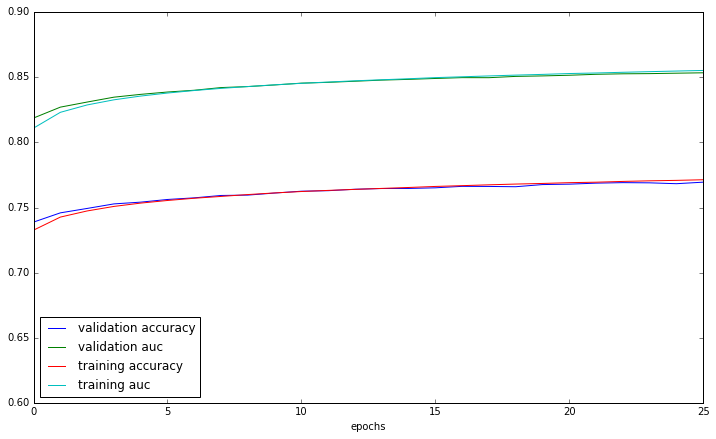

In [28]:
plt.figure(figsize=(12, 7))
plt.plot(val_acc_curve,label='validation accuracy')
plt.plot(val_auc_curve,label='validation auc')
plt.plot(train_acc_curve,label='training accuracy')
plt.plot(train_auc_curve,label='training auc')
plt.xlabel("epochs")
plt.legend(loc='best')
plt.ylim(0.6,0.9);

In [48]:
# And a full pass over the validation data:
val_err = 0
Ypred_batches = []
Ytrue_batches = []
val_batches = 0

for batch in iterate_minibatches(X_val, y_val, batch_size, shuffle=False):
    inputs, targets = batch
    err, y_pred = val_fun(inputs, targets)
    Ypred_batches.append(y_pred)
    Ytrue_batches.append(targets)

    val_err += err
    val_batches += 1

Ypred_val = np.concatenate(Ypred_batches)
Ytrue_val = np.concatenate(Ytrue_batches)
val_acc = accuracy_score(Ytrue_val, Ypred_val>0.5)
val_auc = roc_auc_score(Ytrue_val, Ypred_val)

print val_auc

0.844313305113


In [76]:
lasagne.layers.get_all_params(nn)

[l_0.beta,
 l_0.gamma,
 l_0.mean,
 l_0.inv_std,
 dense0.W,
 dense0_bn.beta,
 dense0_bn.gamma,
 dense0_bn.mean,
 dense0_bn.inv_std,
 dense1.W,
 dense1_bn.beta,
 dense1_bn.gamma,
 dense1_bn.mean,
 dense1_bn.inv_std,
 dense2.W,
 dense2_bn.beta,
 dense2_bn.gamma,
 dense2_bn.mean,
 dense2_bn.inv_std,
 dense3.W,
 dense3_bn.beta,
 dense3_bn.gamma,
 dense3_bn.mean,
 dense3_bn.inv_std,
 dense4.W,
 dense4_bn.beta,
 dense4_bn.gamma,
 dense4_bn.mean,
 dense4_bn.inv_std,
 dense_out.W,
 dense_out.b]

In [29]:
import sys
from six.moves import cPickle as pickle
import lasagne

def save(nn, filename):
    params = lasagne.layers.get_all_param_values(nn)
    with open(filename, 'wb') as fout:
        pickle.dump(params, fout, protocol=2)
        
def save_and_download(nn, filename):
    from IPython.display import FileLink
    
    save(nn, filename)
    return FileLink(filename)

In [30]:
save_and_download(nn, "nn9.weights")

/homeappl/home/trng47/nn9.weights

In [ ]:
from sklearn.metrics import roc_curve
plt.title('Resulting ROC curves')

fpr,tpr,_ = roc_curve(Ytrue_val,Ypred_val)
plt.plot(fpr,tpr,label='validation ROC, auc=%.5f'%(val_auc))
fpr,tpr,_ = roc_curve(Ytrue_train,Ypred_train)
plt.plot(fpr,tpr,label='training ROC, auc=%.5f'%(train_auc))

plt.legend(loc='best')


In [35]:
det_predicted = lasagne.layers.get_output(nn, deterministic=True)
eval_fun = theano.function([input_X], det_predicted[:,1], allow_input_downcast=True, name="eval_NN")

In [36]:
test_prob = eval_fun(test_X)

## Task 1:
Add batch normalization after each hidden layer. See if new network does better that the old one.

To add Batch Normalization, one can use batch_norm:

```
normalized_layer = lasagne.layers.batch_norm(previous_layer)
```

For simplicity, one can implement batch-normalized NN in a new notebook by 
clicking __File__ -> __Make a copy__ in the jupyter notebook top bar. Do not forget to rename the copy.


Alternatively, one can just copy-paste code or start editing


__Bonus task 1.1__:
 - See if batch-normalizing input does you any good.
 - Which operation is this ~equivalent to in terms of Scikit-Learn?
 
 
__ After you made it through batch_normalization, scroll to the notebook bottom for the second assignment__

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

#### Assuming, you made it through the batch-normalization assignment.

__Task2__

If you have seen the batch-normalized NN learning curves, you probably have noticed that the validation curves first ascended to a peak and than started to descend while the training score still increase. That's some __overfitting__ happening right in front of you!

Your second task, and also a reasonable step towards improving your kaggle ensemble, is to get rid of that overfitting by the tools you know already:

- __Early stopping__: stop training when validation score starts decreasing
- __Dropout__: force nn to learn redundant representations using [lasagne.layers.DropoutLayer](http://lasagne.readthedocs.io/en/latest/modules/layers/noise.html) (syntax like batch_norm)
- __L2 or L1 regularization__: plain old weight penalty still works here. Can be implemented using [lasagne.regularization](http://lasagne.readthedocs.io/en/latest/modules/regularization.html)
- __Distortion__: add random (e.g. gaussian) noize to the input data to virtually increase dataset size. 
   * Can be done via [gaussian noise layer](http://lasagne.readthedocs.io/en/latest/modules/layers/noise.html#lasagne.layers.GaussianNoiseLayer) or manually
   
   
A friendly advice:
 - You are not restricted to a single approach, however we recommend slow and methodic changes against mixing everything in random proportions right away.
 - If a method is more mathematically sound or cool than others, it doesn't mean it's bound to score better in competition.
   
Again, the recommended approach is to copy a notebook and solve the task in the copied version, however you may pick ane approach at your own doom.